# Blob detector:

$\sigma = \frac{r}{\sqrt{2}}$

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
#from src.src import *
from numba import jit
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append(math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))

    return np.array(G).reshape(w,h)/np.sum(np.array(G))

In [3]:
@jit
def get_im2col_indices_blur(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

@jit
def conv_octave(im,g,stride=1,C=3):
    im = im[:,np.newaxis,:,:]
    N,_,H,W = im.shape
    _,h,w = g.shape
    
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)

    k,i,j = get_im2col_indices_blur((N,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)

    im_padded = np.pad(im,((0,0),(0,0),(h_pad,h_pad),(w_pad,w_pad)),'mean')
    cols = im_padded[:,k,i,j]
    

    g = g.reshape((N,-1))

    
    sol = np.squeeze(np.matmul(g[:,np.newaxis,:],cols))
    
    return sol.reshape(N,H,W)




In [4]:
def filter_stack(sig0,s,h,w,f=2):
    k = f**(1/s)
    sigma = np.power(k,np.arange(s+1))*sig0
    g = []
    for std in sigma:
        g.append(GaussianFilter(h,w,std))
    return np.stack(g),sigma

In [5]:
def scale_zero2one(M):
    
    min_ = M.min()
    max_ = M.max()
    M = (M-min_)/(max_-min_)

    return M

def Reduce_stack(stack,k):

    N,H0,W0 = stack.shape

    H=H0-H0%(2**k)
    stack = stack[:,:H,:]
    
    W=W0-W0%(2**k)
    stack = stack[:,:,:W]
    
    i = np.repeat(np.arange(0,H,2**k)[np.newaxis,:],W//(2**k),axis=0)
    j = np.repeat(np.arange(0,W,2**k)[:,np.newaxis],H//(2**k),axis=1)


    return np.moveaxis(stack[:,i,j],2,1)

def Reduce(im,k):   
    for j in range(k):
        H,W = im.shape

        Dx = np.zeros((int((H+H%2)/2),H))
        Dx[np.arange(int((H+H%2)/2)),np.arange(0,H,2)]=1

        Dy = np.zeros((int((W+W%2)/2),W))
        Dy[np.arange(int((W+W%2)/2)),np.arange(0,W,2)]=1
        im = (Dx.dot(im)).dot(Dy.T)
    return im


In [6]:
@jit
def get_im2col_indices_conv2d_max(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

def conv2d_max(f,g,k=1,**kwargs):
    #f = f[:,np.newaxis,:,:]
    #f = np.repeat(f,3,axis=1)

    N,H,W=f.shape

    n = np.tile(np.arange(3),N-2) + np.repeat(np.arange(N-2),3)
    f = f[n,:,:].reshape((N-2,3,H,W))

    N,C,H,W = f.shape
    h,w = g

    x_pad = int(0.5*((W-1)*1-W+w))
    y_pad = int(0.5*((H-1)*1-H+w))

    f_pad = np.pad(f,((0,0),(0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='maximum')

    k,i,j = get_im2col_indices_conv2d_max((N,C,H,W), h, w, p_x=x_pad,p_y=y_pad, stride=1)

    cols = f_pad[:,k,i,j]

    xc = int((h*w-1)/2)
    cols = np.delete(cols,(xc,xc+h*w,xc+2*h*w),1)

    cond = ((f[:,1,:,:].flatten() >
             np.max(cols,axis=1).flatten())|(f[:,1,:,:].flatten() <
                                   np.min(cols,axis=1).flatten()))

    return np.moveaxis(cond.reshape(N,H,W),0,2)

In [7]:
def build_sig(xk,sigma):
    sig = np.zeros(xk.shape[0])
    k=0
    for i in xk:
        sig[k] = sigma[i[2]]
        k+=1
    return np.vstack((xk.T,sig)).T
    

In [8]:
@jit
def octave(im_stack,factor,sig0=1.6,s=5,h=3,w=3,f=2):
    g,sigma = filter_stack(sig0,s,h,w,f)
    s1 = np.array([[0,1,0],[0,0,0],[0,-1,0]])
    s2 = np.repeat(s1.T[np.newaxis,:,:],s+1,axis=0)
    s1 = np.repeat(s1[np.newaxis,:,:],s+1,axis=0)
    
    L = conv_octave(Reduce_stack(im_stack,factor),g)
    L = scale_zero2one(L)
    
    D = L[1:s+1] - L[0:s]
    
    
    L_gradx = conv_octave(L,s2)
    L_grady = conv_octave(L,s1)

    return D,L,sigma,(L_gradx,L_grady)

In [9]:
def DoG(img,s=5,factor=1,sig0=1.6,blur_kernel_size=(3,3),f=2):
    N=s+1
    h,w = blur_kernel_size
    im1 = plt.imread(img)
    im1 = np.mean(im1,axis=2)
    im_stack = np.repeat(im1[np.newaxis,:,:],N,axis=0)
    D,L,sigma,(L_gradx,L_grady) = octave(im_stack,factor,sig0,s,h,w,f)

    D_max = np.moveaxis(D[1:-1],0,2)*conv2d_max(D**2,(3,3))
    D_max = scale_zero2one((D_max)**2)
    
    plt.hist(D_max.flatten())
    D_max[D_max<0.15]=0
    xk = np.argwhere(D_max)
    xk = build_sig(xk,sigma)
    return xk,D_max

In [10]:
class BlobDetector:
    def __init__(self,img,s=5,factor=0,sig0=100,blur_kernel_size=(3,3),f=2,treat=False):
        self.img=img
        self.treat = treat
        self.f=f
        self.s=s
        self.factor=factor
        self.sig0=sig0
        self.blur_kernel_size=blur_kernel_size
        self.DoG()
        self.thresholding()
        
    
    def DoG(self):
        img = self.img
        s=self.s
        factor=self.factor
        sig0=self.sig0
        blur_kernel_size=self.blur_kernel_size
        
        N=s+1
        h,w = blur_kernel_size
        im1 = plt.imread(img)
        if self.treat==True:
            im1 = treat_im(im1)
        
        im1 = np.mean(im1,axis=2)
        im_stack = np.repeat(im1[np.newaxis,:,:],N,axis=0)
        D,L,sigma,(L_gradx,L_grady) = octave(im_stack,factor,sig0,s,h,w,self.f)

        D_max = np.moveaxis(D[1:-1],0,2)*conv2d_max(D,(3,3))
        
        self.D_max = D_max
        self.sigma=sigma
    
    def thresholding(self,th=0.03):
        D_max = self.D_max.copy()
        D_max = scale_zero2one(D_max**2)
        D_max[D_max<th]=0
        self.xk = np.argwhere(D_max)
        self.xk = build_sig(self.xk,self.sigma)
    
    def plot(self):
         
        im = plt.imread(self.img)
        if self.treat==True:
            im = treat_im(im)
        im = Reduce(np.mean(im,axis=2),self.factor)
  
        
        kp = self.xk
        
        plt.imshow(im,**{'cmap':'gray'})

        a = kp[:,0]
        b = kp[:,1]
        R = kp[:,3]*np.sqrt(2)*(2**self.factor)

        plt.scatter(b,a,s=R,facecolors='none',edgecolors='r',linewidths=.1)
        plt.show()
        
        plt.hist(self.xk[:,3])
        pass
        
        
        

In [11]:
Blob1 = BlobDetector('img/butterfly.jpg',
                     s=30,
                     sig0=50,
                     f=8,
                     blur_kernel_size=(3,3))

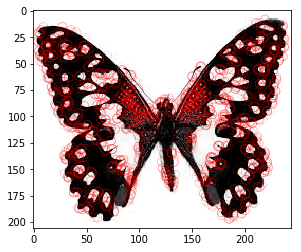

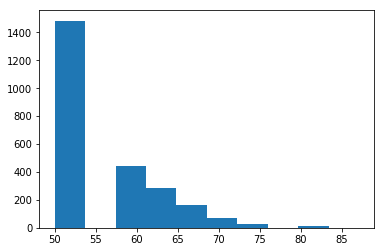

In [12]:
Blob1.thresholding(0.1)
Blob1.plot()

In [13]:
Blob1 = BlobDetector('img/canny.jpeg',
                     s=50,
                     sig0=200,
                     f=3,
                     factor=0,
                     blur_kernel_size=(5,5))

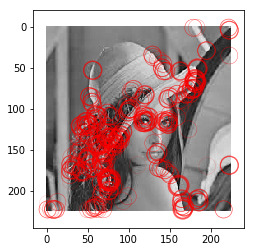

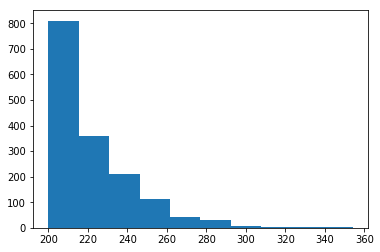

In [14]:
Blob1.thresholding(0.1)
Blob1.plot()

In [15]:
Blob1 = BlobDetector('img/farol1.jpg',
                     s=50,
                     sig0=200,
                     f=3,
                     factor=2,
                     blur_kernel_size=(5,5))

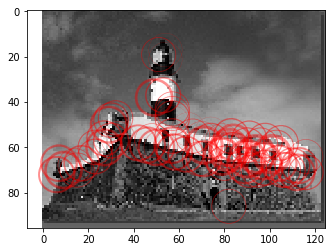

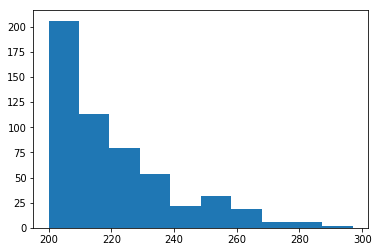

In [16]:
Blob1.thresholding(0.2)
Blob1.plot()

In [18]:
im = plt.imread("img/coins1.jpg")

im.shape

def plot(img,**kwargs):
    plt.figure()
    plt.imshow(img,interpolation="none",**kwargs)
    plt.axis('off')

def Reduce_stack(stack,k):

    N,H0,W0 = stack.shape

    H=H0-H0%(2**k)
    stack = stack[:,:H,:]
    
    W=W0-W0%(2**k)
    stack = stack[:,:,:W]
    
    i = np.repeat(np.arange(0,H,2**k)[np.newaxis,:],W//(2**k),axis=0)
    j = np.repeat(np.arange(0,W,2**k)[:,np.newaxis],H//(2**k),axis=1)


    return np.moveaxis(stack[:,i,j],2,1)

def conv2d_median(f,size=(3,3),k=1,**kwargs):
    w,h = size
    W,H,D = f.shape
        
    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))
        
    f_pad = np.pad(f,((y_pad,y_pad),(x_pad,x_pad),(0,0)),mode='constant')
    
    new_im = []
    for m in range(int(f_pad.shape[0]-w)+1):
        for n in range(int(f_pad.shape[1]-h+1)):
            new_im.append(np.median(f_pad[m:m+w,n:n+h,:],axis=(0,1)))
            
            
    return np.array(new_im).reshape(W,H,D)

def treat_im(im):
    im = conv2d_median(im,size=(11,11),k=1)
    return im

In [19]:
Blob1 = BlobDetector('img/coins1.jpg',
                     s=50,
                     sig0=10,
                     f=1,
                     factor=3,
                     blur_kernel_size=(21,21),
                     treat=True)

/home/alien/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/alien/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less


/home/alien/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/alien/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less


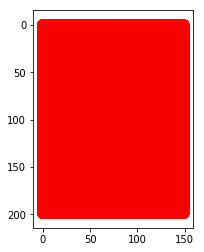

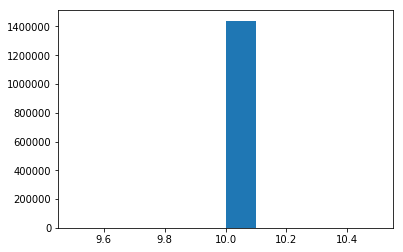

In [20]:
Blob1.thresholding(0.2)
Blob1.plot()